Author: Lewis Li

## Introduction

In this notebook, we will demonstrate the application of Sequential Importance Sampling to generate reservoir models that match the predictions generated by Evidential Learning. There are two main motivations for this workflow. The first is to recover the reservoir model parameters that correspond to Evidential Learning, which can be used for quality checking and other physical simulations. The second pertains to the situation where the observed data resides within the tails of the prior distribution. Under these circumstances, it may be helpful to generate additional models in the vicinity of the observed data in order to refine our prediction. Moreover, such a workflow can be applied as additional data becomes available (the data assimilation problem).

<img src="../figures/SIR/FieldOverview.png",width="600",style="float: center">

We will consider the same Libyan reservoir as the Evidential Learning tutorial. Our goal is to predict the performance of a new infill to be drilled at location PNEW after 8000 days of production using the production rates from the five existing producers after different periods of time. 



## Targeted Sampling With SIR
We propose to use Sequential Importance Resampling (SIR) to obtain subsurface models from $f(\mathbf{m}|\mathbf{d}_{obs})$ (which we will refer to as thetarget distribution). Importance sampling is a well-known statistical method that uses a different proposal distribution to focus the sampling of the target distribution of interest, with the aim to make such sampling more efficient (e.g. sample more the tail than the center). It is a variance reduction method that is used in conjunction with Monte Carlo, that emphasizes sampling more in the regions considered to be more important. However, the use of a different distribution will result in a biased estimate of the underlying variable, therefore to compensate, a weight must be attached to each sample.  The weight is equivalent to the likelihood ratio between the underlying target distribution and the biased proposal distribution. We propose a simple proposal distribution for each model parameter based on Bayes’ Rule. Since the actual target distribution $f(\mathbf{m}|\mathbf{d}_{obs})$ remains unknown, we propose instead to use the posterior distribution of $\mathbf{h}$ as a summary statistic to thus perform the weighting.

<img src="../figures/SIR/Flowchart.png",width="600",style="float: center">

### Importance Sampling
Before we discuss the specific target function $f(\mathbf{m}|\mathbf{d}_{obs})$, let us first consider sampling an arbitrary \acs{RV} $\mathbf{x}$ which has values given by $v(\mathbf{x})$ and \acs{pdf} $p(\mathbf{x})$. Suppose we wish to compute the expected value of $\mathbf{x}$ using Monte Carlo. We would proceed as:
$$
E\left[ v(\mathbf{x}) \right]  =  \int v(\mathbf{x}) p(\mathbf{x}) d\mathbf{x} \approx \frac{1}{N} \sum_{i=1}^N v(\mathbf{x}_i) p(\mathbf{x}_i) \\
\mathbf{x}_i  \sim  p(\mathbf{x}) 
$$
That is we would sample $\mathbf{x}$ from $p(\mathbf{x})$ and use it to evaluate the expected value. We see that each sample generated $\mathbf{x}_i$ is equivalently weighted when computing the expected value. However, if $p(\mathbf{x})$ is difficult to sample (i.e. we are only interested in the tail region), a large number of samples of $\mathbf{x}$ would be required in order for the statistic (in this case the mean) to converge. Importance sampling introduces a new distribution termed the *proposal* distribution denoted $q(\mathbf{x})$, and rewrites the previous expression as:
$$
E\left[ v(\mathbf{x}) \right]  = \int \frac{p(\mathbf{x})}{q(\mathbf{x})} v(\mathbf{x}) q(\mathbf{x}) d\mathbf{x} \approx \frac{1}{N} \sum_{i=1}^N \frac{p(\mathbf{x_i})}{q(\mathbf{x_i})} v(\mathbf{x}_i) q(\mathbf{x}_i) \\
\mathbf{x}_i \sim q(\mathbf{x}) 
$$
The distinction is now the samples $\mathbf{x}_i$ are drawn from $q(\mathbf{x})$. Furthermore, instead of each sample being equi-probable, they have a weight associated with it:
$$
w_i = \frac{p(\mathbf{x}_i)}{q(\mathbf{x}_i)}
$$
This weight is required to correct for the bias that results from sampling from $q(\mathbf{x})$. The choice of the proposal distribution is clearly fundamental for importance sampling, as an appropriate choice can result in dramatic decrease in number of required samples, while a poor distribution can result in even slower convergence than regular Monte Carlo.

### A 1D Gaussian Example
Suppose we are trying to estimate $P(x > 4)$ where $x \sim \mathcal{N}(0,1)$. Regular Monte Carlo would require a large number of samples to estimate this probability as very few samples drawn from $f(x) = \mathcal{N}(0,1)$ would be greater than $4$. Let us try it first with 10000 samples.


In [1]:
nSamples = 10000;

% Generate samples from target distribution
x = randn(nSamples,1);

estimate_mc = sum(x>4)/nSamples

estimate_mc =

     0


With 1000 samples, chances are Monte Carlo will return a value of 0 or $10^{-5}$. Let us try importance sampling with the proposal function $q(x) = \mathcal{N}(4,2)$. 

In [2]:
% Generate samples from proposal distribution
q_x = randn(nSamples,1)*2 + 4;

% Evaluate the weight
pdf_q = normpdf(q_x,4,2);
pdf_p = normpdf(q_x,0,1);
w = pdf_p./pdf_q;

estimate_is = mean(w.*(q_x>4))

% Analyical solution
analyical_solution = 1-normcdf(4,0,1)

estimate_is =

   3.0994e-05


analyical_solution =

   3.1671e-05


If we compare the importance sampling estimate to the analytical solution, we can see that importance sampling yields a much closer estimate than Monte Carlo with the same number of samples. This illustrates that the sampling is more efficient than conventional Monto Carlo. We next explore how this concept can be applied to sub-surface modeling

## SIR For Subsurface Modeling
Before, we examine the specifics of the target and proposal distribution, let us consider the uncertanties that we have on the model. We will examine 12 non-gridded parameters pertain to the reservoir fluid characteristics (relative permeability, oil viscosity, etc), as well as the transmissibility of the four faults in the reservoir. The prior on these parameters is shown below:

Name  |  Symbol |  Prior $f(m_i)$ 
-----------------------|--------------------|--------------------
Oil Water Contact | $OWC$ |  $\mathcal{U}[1061,1076]$ 
Fault 1 Transmissibility Multiplier | $F_1$ | $\mathcal{U}[0,1]$
Fault 2 Transmissibility Multiplier | $F_2$ | $\mathcal{U}[0,1]$
Fault 3 Transmissibility Multiplier | $F_3$ | $\mathcal{U}[0,1]$
Fault 4 Transmissibility Multiplier | $F_4$ | $\mathcal{U}[0,1]$
Oil Viscosity | $\mu$ | $\mathcal{N}(4,0.5)$ 
Irreducible Oil Saturation | $S_{or}$ | $\mathcal{N}(0.2,0.05)$ 
Irreducible Water Saturation | $S_{wc}$ | $\mathcal{N}(0.2,0.05)$ 
Oil End Point Relative Perm K | $k_{ro}$ | $\mathcal{U}[0.1,0.4]$ 
Water End Point Relative Perm K | $k_{rw}$ | $\mathcal{U}[0.1,0.4]$ 
Corey Coefficient Oil | $n_{o}$ | $\mathcal{U}[2,3]$ 
Corey Coefficient Water | $n_{w}$ | $\mathcal{U}[4,6]$ 

### The Target Distribution
The target distribution that we wish to sample is:

$$f(\mathbf{m}|\mathbf{d}_{obs}) = f(m_1,m_2,..., m_{12}|\mathbf{d}_{obs})$$

This represents the set of reservoir models that generates $\mathbf{d}$ that matches $\mathbf{d}_{obs}$. This is a high dimensional distribution (in this case 12D) that cannot be directly specified nor sampled. We can imagine that very few combinations of $\left\lbrace m_1,\cdots,m_{12}\right\rbrace$ would yield a $\mathbf{d}$ that matches $\mathbf{d}_{obs}$, necessitating the application of SIR.

### The Proposal Distribution
if we consider each component of $\mathbf{m}$ independently $m_n$, we then write the target distribution as $f(m_1,m_2,..., m_N|\mathbf{d}_{obs})$. If we make the assumption of *conditional independence* between each of the model components, then a possible choice of a proposal distribution is:
$$q(m_1,m_2,..., m_N|\mathbf{d}_{obs}) = \prod_{n=1}^N f(m_n|\mathbf{d}_{obs})$$

In general, this assumption of conditional independence is not true, thus sampling from $q(\mathbf{m})$ introduces a bias. We will correct for this bias in the next section. However, estimating each of the $f(m_n|\mathbf{d}_{obs})$ distributions is a far easier task than the entire posterior. Since $m_n$ is a single parameter and thus univariate, it can be estimated using conventional statistical approaches such as Kernel Density Estimation. The procedure can be summarized as:

1. Construct prior models by sampling from $f(\mathbf{m})$ using Monte Carlo and/or geostatistical simulation.
2. Forward simulate using $g_d(\cdot)$ each of the prior models to generate prior realizations of $\mathbf{d}$.
3. Apply any necessary dimension reduction on $\mathbf{d}$ and $\mathbf{d}_{obs}$ to yield $\mathbf{d}^*$ and $\mathbf{d}^*_{obs}$.
4. Estimate $f(m_n|\mathbf{d}^*_{obs})$ for each $m_i$ using KDE


## Construction of the Prior Models
We begin by sampling our prior models by applying Monte Carlo on the prior distributions shown in the table above. We generated 500 prior models and forward simulated them to 12000 days using 3DSL. After 1000 days, we would like to make our first prediction regarding the future production of the new well. We begin by loading both the **prior** and **observed** data at 1000 days. The results were processed from the 3DSL output into the same struct described in the EvidentialLearning notebook.

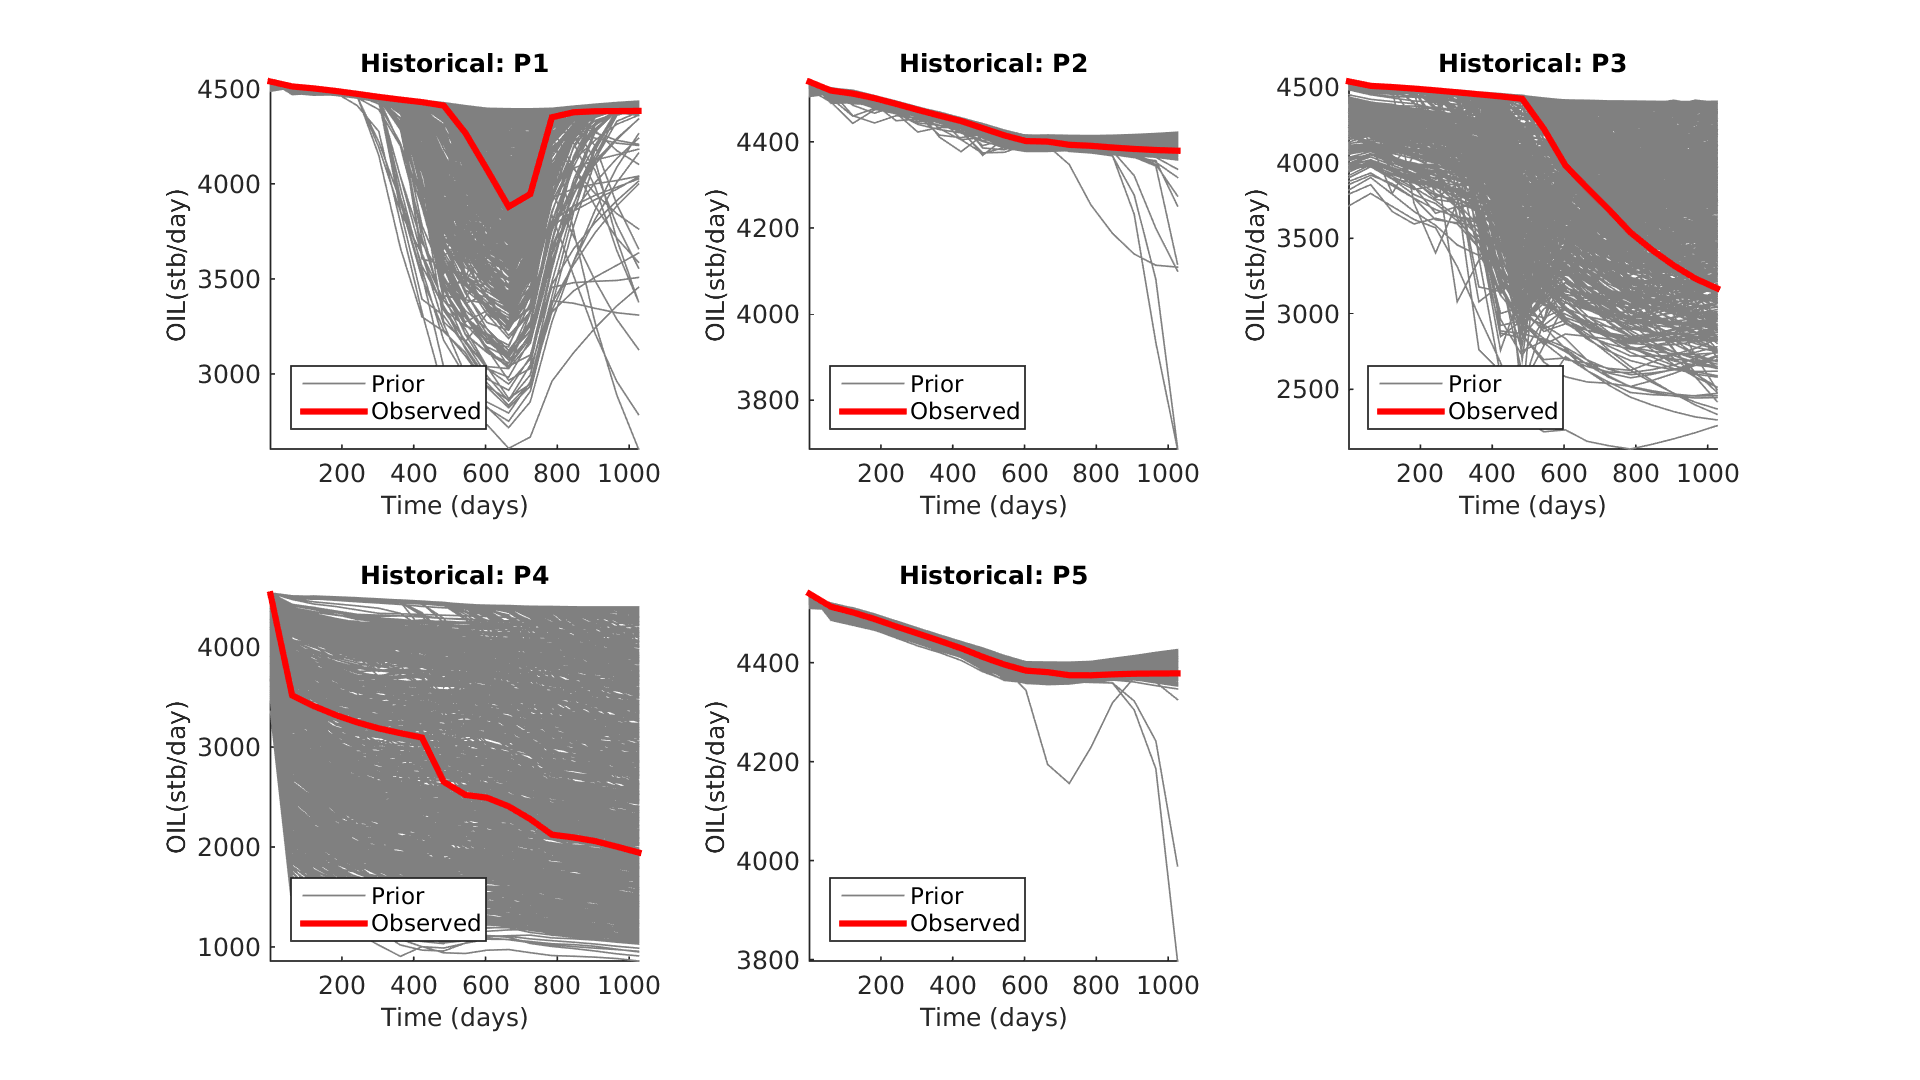

In [3]:
%plot inline -s 1920,1080
addpath('../src/evidential/');
addpath('../src/sir/');

load('../data/SIR/3dslresults/Time1000/Prior.mat');
load('../data/SIR/3dslresults/Time1000/Observed.mat')

FontSize = 12;
PlotResponses(PriorData,TrueData,FontSize);

Likewise, we can visualize the prior prediction variable

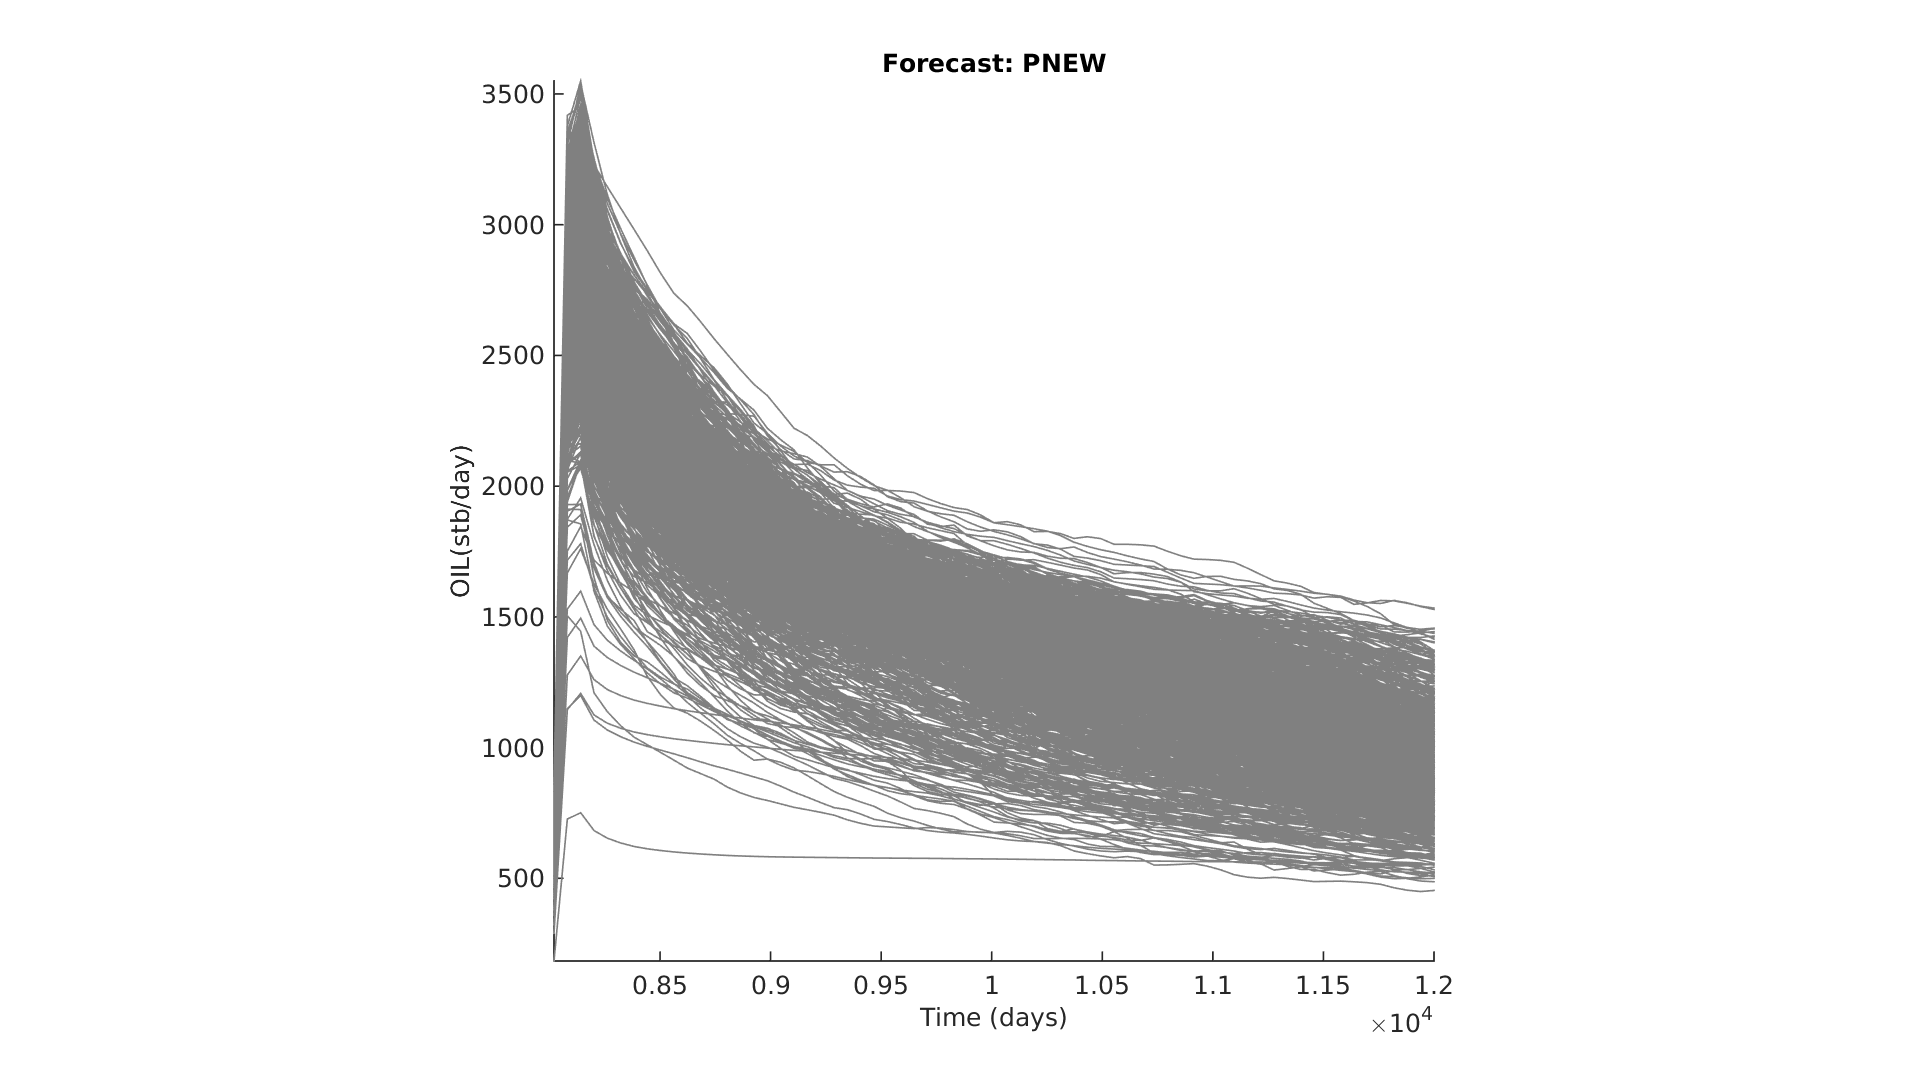

In [4]:
PlotResponses(PriorPrediction,[],FontSize);

We next load the parameters that correspond to each of the prior models. 

In [5]:
load('../data/SIR/parameters/Prior/Sampled.mat');
load('../data/SIR/parameters/ParameterNames.mat');

## Estimating The Proposal Distribution
To estimate the proposal distribution, we will perform dimension reduction on the data variable, and then apply Kernel Density Estimation on each of the model parameters.

### Dimension Reduction
We begin by applying Functional Data Analysis followed by Mixed PCA on both the data and observed data responses.

In [6]:
addpath('../src/thirdparty/fda_matlab/');

% Compute FPCA on prior data + observed data
data_FPCA = ComputeHarmonicScores(PriorData,TrueData,0);

% ComputeHarmonicScore stacks the observed data as the last row of the
% resulting scores
obs_realization = size(PriorData.data,1) + 1;

% Perform Mixed PCA 
eigentolerance = 0.9;
rmpath('../src/thirdparty/fda_matlab/');
[mpca_scores, mpca_obs] = MixedPCA(data_FPCA,obs_realization,...
    eigentolerance);

### Kernel Density Estimation of $f(m_i|\mathbf{d}_{obs})$

We begin by examining the scatter plot of the prior models according to their first two functional components. The red star represents the location of $\mathbf{d}^{mpca}_{obs}$ in functional space. We would thus expect the prior models located closest to $\mathbf{d}^{mpca}_{obs}$ to have $m_i$ values that yield $\mathbf{d}^{mpca}_{obs}$ when forward simulated. If we color the scatter plot by the values of a given $m_i$ (in this case OWC), we observe a trend amongst the prior models and their OWC values. Seemingly, the prior models that yield $\mathbf{d}^{mpca}$ closest to $\mathbf{d}^{mpca}_{obs}$ seem to have OWC values of around 1070.

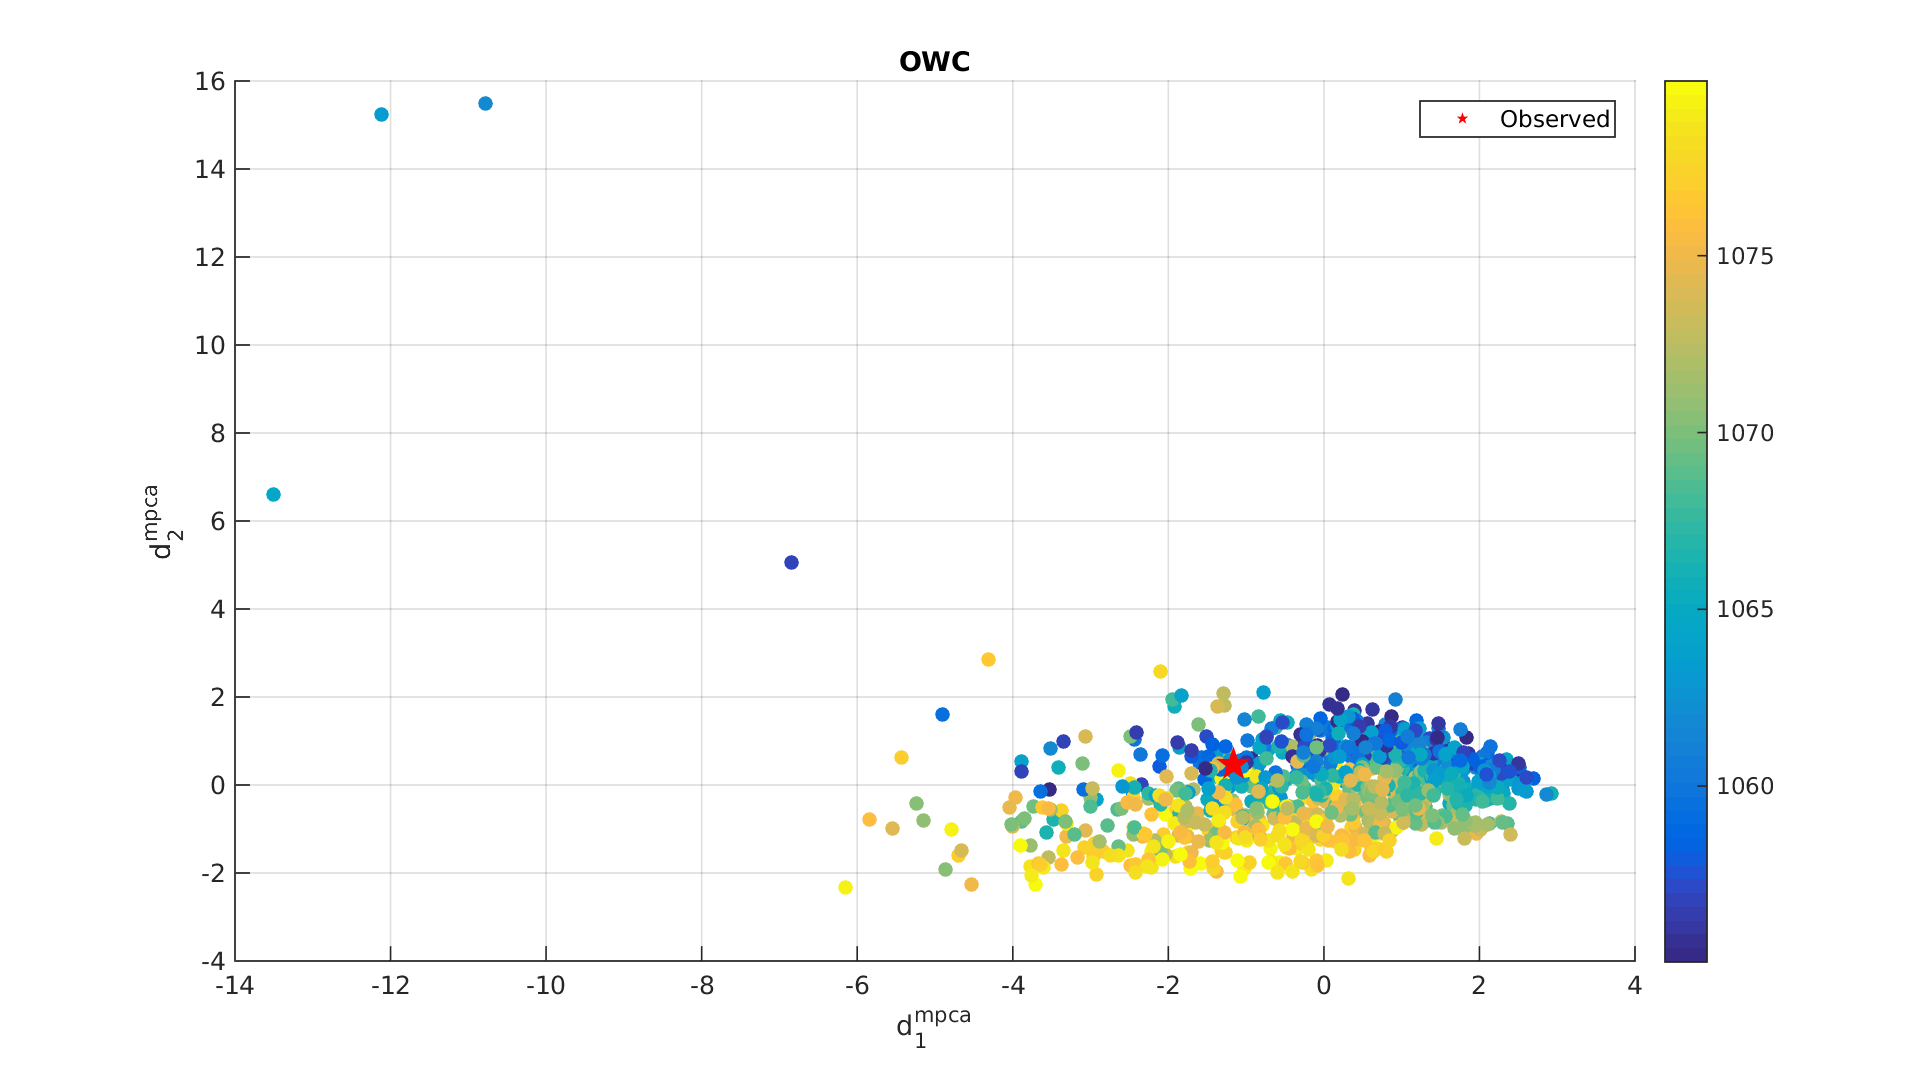

In [7]:
ParameterName = 'OWC';
ParameterValues = ModelParameterValues.(ParameterName);

hold on;
scatter(mpca_scores(:,1),mpca_scores(:,2),50,ParameterValues,'filled');
h1=scatter(mpca_obs(:,1),mpca_obs(:,2),300,'r','filled','p');
legend(h1,'Observed'); xlabel('d^{mpca}_1'); ylabel('d^{mpca}_2');
set(gcf,'color','w'); set(gca,'fontsize',FontSize); 
grid on; colorbar; title(ParameterName);

To formalize this, we will apply KDE on both the functional components as well as the $m_i$ values. Therefore, the dimensional of the KDE is equal to $dim(\mathbf{d}^{mpca}) + 1$.  The conditional probability of a given parameter value is obtained by taking a slice of the KDE result. By repeating this over all possible values of $m_i$ and normalizing, we can obtain the entire probability $f(OWC|\mathbf{d}_{obs})$. This is implemented in _UpdateProbabilityContinuous.m_, along with the details of how the bandwidth for this specific KDE is chosen.

In [8]:
addpath('../src/thirdparty/likelihood_continuous/');
mpca_stacked = [mpca_scores; mpca_obs];
[ParamValues,ParamPDF] = UpdateProbabilityContinuous(mpca_stacked,ParameterValues);

We can overlay this estimated PDF with the prior PDF to visualize the reduction in parameter uncertainty that $\mathbf{d}_{obs}$ is able to provide.

In [ ]:
% Compute empirical prior distribution using prior models
[prior_f,prior_xi] = ksdensity(ParameterValues);

hold on;
plot(prior_xi,prior_f,'k','linewidth',2);
plot(ParamValues,ParamPDF,'b','linewidth',2)
legend('Prior','Proposal'); axis tight;
set(gca,'fontsize',FontSize); xlabel(ParameterName); ylabel('PDF');

We then repeat this for each of the 12 uncertain parameters, which will then allow us to construct $\prod_{n=1}^{12} f(m_n|\mathbf{d}_{obs})$. *Note this can take a while to run*

In [ ]:
NumParameters = length(ParameterNames);

NumPDFPoints = 100;
ProposalParameterVal = zeros(NumPDFPoints,NumParameters);
ProposalPDFs = zeros(NumPDFPoints,NumParameters);

% Stack mpca_scores and mpca_obs to compute probability
mpca_stacked = [mpca_scores; mpca_obs];

for i = 1:NumParameters
    ParameterName = ParameterNames{i};
    ParameterValues = ModelParameterValues.(ParameterName);
   
    % Kernel Density Estimation
    [ProposalParameterVal(:,i),ProposalPDFs(:,i)] = ...
        UpdateProbabilityContinuous(mpca_stacked,ParameterValues);
end


We next visualize the proposal distributions in comparison with the prior for a subset of the 12 realizations. 

In [ ]:
for i = 1:4
    subplot(2,2,i);
    
    ParameterName = ParameterNames{i};
    ParameterValues = ModelParameterValues.(ParameterName);
    
    [prior_f,prior_xi] = ksdensity(ParameterValues);
    
    hold on;
    plot(prior_xi,prior_f,'k','linewidth',2);
    plot(ProposalParameterVal(:,i),ProposalPDFs(:,i),'b','linewidth',2)
    legend('Prior','Proposal'); axis tight;
    set(gca,'fontsize',FontSize); xlabel(ParameterName); ylabel('PDF');
    
end

## Construction of Proposal Models
Once the proposal distributions have been estimated, we can sample from each of the 12 distributions independently to construct a set of proposal models. This is implemented using the _SampleNewProposalModels.m_ function.

In [ ]:
NumProposalModels = 500;
PlotLevel = 0;
ProposalModelParameters = SampleNewProposalModels(ProposalParameterVal, ProposalPDFs,...
    NumProposalModels,ParameterNames,PlotLevel);

_ProposalModelParameters_ thus contains the set of parameters that define the proposal models. The next step is to forward simulate these models using 3DSL. We use the _WriteSimulationDeck.m_ and _PreparePBS.m_ functions to construct the data decks for 3DSL as well as the batch scripts for running the required forward simulations in parallel on a computer cluster. These will need to be replaced accordingly depending on the simulator/cluster. 

### Load Proposal Models Results
After the proposal models have been forward simulated, we process the simulator output just as we did for the prior models, and store the results in the same struct format. The data variable is still the 1000 days worth of historical production from the 5 existing wells, and the prediction variable is the future production of the new well.

In [ ]:
load('../data/SIR/3dslresults/Time1000/Observed.mat')
load('../data/SIR/3dslresults/Time1000/Proposal.mat');
load('../data/SIR/3dslresults/Time1000/Prior.mat');

We can visualize the data variable corresponding to the proposal models.

In [ ]:
PlotResponses(ProposalData,TrueData,FontSize);

Likewise, we can also visualize the proposal model prediction variable

In [ ]:
PlotResponses(ProposalPrediction,[],FontSize);

## Correcting The Bias
While the proposal model prediction variable exhibits smaller uncertainty than the prior, we need to keep in mind that it is a biased estimated of the posterior. This is due to the fact that we sampled the proposal distribution instead of the target distribution. Let us denote each proposal model as $\mathbf{m}_q^{(l)}$. To correct for the bias, we need to compute a weight for each proposal model $w^{(l)}$. Using our earlier definition, we can express the weight as:

$$w^{(l)} = \frac{f(\mathbf{m}_q^{(l)}|\mathbf{d}_{obs})}{q(\mathbf{m}_q^{(l)}|\mathbf{d}_{obs})}$$

$$w^{(l)} = \frac{f(m_{q,1}^{(l)},m_{q,2}^{(l)}, \cdots, m_{q,N}^{(l)}|\mathbf{d}_{obs})}{\prod_{n=1}^N f(m^{(l)}_{q,n}|\mathbf{d}_{obs})}$$

However, we realize that in order to evaluate the weight, we need to be able to evaluate $f(m_{q,1}^{(l)},m_{q,2}^{(l)}, \cdots, m_{q,N}^{(l)}|\mathbf{d}_{obs})$ for each proposal model. Unfortunately, this is not possible as the numerator represents the high dimensional target distribution that we cannot specify. Instead, we will need some way to approximate this ratio. To do this, we replace the high dimensional subsurface model $\mathbf{m}$ with a proxy. Such a proxy would need to be a function of $\mathbf{m}$. One candidate is the prediction variable $\mathbf{h}$, since it is linked to $\mathbf{m}$ through the forward simulator $g_h(\cdot)$. We thus rewrite the weight as:

$$w^{(l)}  \approx \frac{f(g_h(\mathbf{m}_q^{(l)})|\mathbf{d}_{obs})}{q(g_h(\mathbf{m}_q^{(l)})|\mathbf{d}_{obs})} = \frac{\hat{f}(\mathbf{h}_q^{(l)})|\mathbf{d}_{obs})}{\hat{f}_q(\mathbf{h}_q^{(l)})|\mathbf{d}_{obs})} $$

$\hat{f}(\cdot)$ represents the conditional distribution of the prediction variable as estimated from the prior subsurface models using evidential learning. The $\hat{f}_q(\cdot)$ represents the conditional distribution of the prediction variable as estimated using the proposal models and.  In practice, this would be done on the reduced and transformed versions of the data and prediction variables ($\mathbf{d}^*$ and $\mathbf{h}^*$). Let us first compute $\hat{f}(\cdot)$. We use the same methodology as in the Evidential Learning tutorial, where we first apply FPCA/Mixed PCA followed by CCA and a Normal Score Transform. The posterior is then evaluated using Linear Gaussian Regression. This entire workflow is implemented in _ComputePosteriorPrediction.m_


In [ ]:
EigenTolerance = 0.95;
C_D  = 0;
PlotLevel = 0;

% First step is to compute f(h|d_{obs}) using Evidential Learning
[mu_Target,C_Target,DcPrior,HcPrior, dobs_c]=ComputePosteriorPrediction(...
    PriorData, PriorPrediction, TrueData, EigenTolerance,C_D,PlotLevel);

To compute $\hat{f}_q(\cdot)$, we need to ensure that the proposal models are projected onto the same support as the prior models during evential learning. This means that the same eigenfunctions and CCA transformation must be applied. We implement this in _ComputeCanonicalOnExternalBasis.m_. (This may take a while to run, so instead we will save and load the coordinates for the purposes of this notebook).

In [ ]:
%[DcProposal,HcProposal] = ComputeCanonicalOnExternalBasis(PriorData,...
%    PriorPrediction,ProposalData,ProposalPrediction,EigenTolerance,TrueData);

load('../data/SIR/3dslresults/Time1000/ProposalCanonical.mat');

We can verify the performance of our proposal models by overlaying them on top of the prior models in canonical space.  We see that the proposal models (red points) are clustered closer to $\mathbf{d}^c_{obs}$ in comparison with the prior models (black points). However, we also can see that the proposal models are not perfectly clustered around $\mathbf{d}^c_{obs}$, and still exhibit some variance in the x-axis. This is due to interactions between parameters that is not accounted for in our construction of the proposal distribution, and the exact reason why the bias correction is required! 

In [ ]:
hold on;
h1=scatter(DcPrior(:,1),HcPrior(:,1),50,[0.5,0.5,0.5],'filled');
h2=scatter(DcProposal(:,1),HcProposal(:,1),'filled');
h3=plot([dobs_c(1), dobs_c(1)], [min(HcPrior(:,1)), max(HcPrior(:,1))],...
    'r','linewidth',2.0);
legend([h1(1), h2(1), h3],'Prior','Proposal','Observed');
axis tight; grid on; xlabel('d^c_1'); ylabel('h^c_1');
set(gcf,'color','w'); set(gca,'fontsize',FontSize);

Recall that the weights are approximated using the ratio of the conditional distribution of the prediction variable as estimated from the prior reservoir models $\hat{f}(\cdot)$ and the conditional distribution estimated from the proposal reservoir models $\hat{f}_q(\cdot)$. However, practically speaking, these distributions are computed in some reduced dimensional space. In this case, the weights are computed in the canonical space. Therefore, we computed the weights as the ratio of the conditional probabilities of the first canonical component of the prediction variable $\mathbf{h}^{c_1}_q$:

$$w^{(l)} \approx \frac{\hat{f}({\mathbf{h}^{c_1}_q}^{(l)})|\mathbf{d}^c_{obs})}{\hat{f}_q({\mathbf{h}^{c_1}_q}^{(l)})|\mathbf{d}^c_{obs})}$$

To evaluate the weights, we will need to compute the densities.

In [ ]:
% Apply kernel density estimation to get density of
% \hat{f}(h^\star)
[fPrior,xPrior] = ksdensity(HcPrior(:,1));

% Apply kernel density estimation to get density of
% \hat{f}(h^\star|d_obs)
[fProposal,xProposal] = ksdensity(HcProposal(:,1));

% Get density of f(h^\star|d_obs) from evidential learning on prior
NumPointsForDensity = 1000;
xTarget = linspace(min(xPrior),max(xPrior),NumPointsForDensity);
fTarget = normpdf(xTarget,mu_Target(1),(C_Target(1,1)));

We can plot the prior, proposal and target distributions on top of each other to ensure that our choice of proposal distribution is indeed appropiate. 

In [ ]:
CurrentTime=1000; hold on;
plot(xPrior,fPrior,'k','LineWidth',3);
plot(xProposal,fProposal,'r','LineWidth',3);
plot(xTarget,fTarget,'b','LineWidth',3);
title(['Distributions After ' ...
    num2str(CurrentTime) ' days']);
h = legend('Prior: $f(h^\star)$',...
    'Proposal: $\hat{f}(h^\star|d_{obs})$',...
    'Target: $f(h^\star|d_{obs})$');
set(h,'Interpreter','latex','FontSize',FontSize,'FontWeight','bold',...
    'Location','best')
xlab = xlabel('$h^\star$'); ylab = ylabel('PDF','FontSize',FontSize);
set(xlab,'Interpreter','latex','FontSize',FontSize);
axis tight; set(gcf,'color','w'); set(gca,'FontSize',FontSize); grid on;

For each proposal model we can then evaluate the weight for each realization using the densities estimated in the previous block. The weights are then normalized as can be seen in *_ComputeModelWeights.m*.

In [ ]:
[WNorm] = ComputeModelWeights( HcProposal, fProposal, xProposal,...
    fTarget, xTarget);

We see that the proposal model that concur with the unbiased posterior $\hat{f}({\mathbf{h}^{c}_q})|\mathbf{d}^c_{obs})$ are assigned the highest weight. Conversely, proposal models that did not agree with neither the posterior prediction nor $\mathbf{d}_{obs}$ are assigned very low weights (i.e models in the top right corner).

In [ ]:
%plot inline -s 1920,1080
PlotModelsByWeight( HcPrior,DcPrior,HcProposal,...
    DcProposal,dobs_c,WNorm,FontSize);

### Updated Predictions
SIR attempts to address the inefficiency of the prior distribution in generating samples in regions where it matters: near observed data and where it is important for prediction. The proposal distribution is more efficient in drawing samples that aid prediction as it does take into account. However, the independence assumption in the proposal function ignores the dependency created by the conditioning to observed data (even if prior model variables are independent). These weights represent how much each proposal model is in accordance with the data-prediction statistical relationship established from the original prior distribution. This means that proposal models that do not contribute to prediction uncertainty will get low weight. The posterior of the prediction variables is then computed using these weights and the proposal model predictions. The quantiles compare well to those obtained from evidential learning with the important distinction that we now have the model parameters that correspond to the posterior predictions!

In [ ]:
FontSize = 20;
hQuantiles = PlotUpdatedQuantiles(PriorPrediction,...
    ProposalPrediction,TruePrediction,HcProposal,WNorm,CurrentTime,FontSize);

## Assimilation of Additional Data
SIR retains the Bayesian formulation of evidential learning, as additional information is collected (e.g. $\mathbf{d}_{obs}$ is measured over a longer period of time), the posterior is iteratively updated. At the $t^{th}$ instance that new data (denoted $\mathbf{d}_{obs,t}$ becomes available, and this process is repeated. The sequential repetition of SIR may result in so-called sample *degeneracy*. Degeneracy is defined as an increasing skewness of the SIR weights i with each iteration (Fox,2003). This is due to the weights being multiplicatively updated. This means that after a few iterations, a few of the proposal samples will have weights that are much larger than the others. This is not useful, as the goal was to generate multiple samples that are in the vicinity of $\mathbf{d}_{obs}$, and instead the algorithm is spending computational time updating low weight models. The solution to this is to apply a resampling step. Resampling works by first normalizing each of the computed proposal weights, and then interpreting each normalized weight as the probability of each sample.

We then redraw $L$ samples according to this discrete probability distribution. This removes the low weight samples, and increase the number of high weight samples. The rationale behind this is that if a sample has low weight at time $t$, it will still have low weight at time $t+1$. A variety of other resampling techniques have been proposed to accomplish this in a systematic manner. An overview of such techniques can be found in (Douc,2005). We will use the approach termed _SystematicResampling_.

In [ ]:
R = [DcProposal(:,1) HcProposal(:,1)];
[RNewSystematic, WNewSystematic, IndexAfterResampling] = ...
    SystematicResampling(R,WNorm);

PlotModelsByWeight(HcPrior,DcPrior,RNewSystematic(:,2),...
    RNewSystematic(:,1),dobs_c,...
    WNewSystematic,FontSize);

This effectively removes the low weighted proposal models that do not contribute to the posterior uncertainty. The proposal models that remain after resampling are used in subsequent iterations of SIR.

### Next Iteration of SIR
Let us suppose 1000 days have passed, and we would like to perform a second iteration of SIR using the additional 1000 days worth of observed data, and the resampled models from the previous iteration. We begin by loading the previous iteration's proposal model parameters:

In [ ]:
CurrentTime = 2000;
load('../data/SIR/parameters/TimeStep1000/Sampled.mat');
LastIterationProposalParameters = CurrentIterationParameters;

We next need to forward simulate the prior and proposal models from the previous iteration to 2000 days using 3DSL and then importing the results.

In [ ]:
load('../data/SIR/3dslresults/Time2000/Observed.mat')
load('../data/SIR/3dslresults/Time2000/Prior.mat')

We can then recompute the proposal distributions using this additional 1000 days worth of information. The previously outlined steps for estimating the proposal distribution are implemented as function in _EstimateProposalDistribution.m_. We denote this $q(\mathbf{m}|\mathbf{d}_{obs})_{2000}$

In [ ]:
ObservedData = TrueData;
[ProposalParameterVal,ProposalPDFs] = EstimateProposalDistribution(...
    PriorData,ObservedData,LastIterationProposalParameters);

After we estimate the new proposal distributions, we can sample a new set of proposal models. 

In [ ]:
NumProposalModels = 500;
PlotLevel = 0;
ProposalModelParameters = SampleNewProposalModels(ProposalParameterVal, ...
    ProposalPDFs,NumProposalModels,ParameterNames,PlotLevel);

These new proposal models need to be once again forward simulated in 3DSL to generate the updated proposal data and prediction variables. We then load the post-processed results:

In [ ]:
load('../data/SIR/3dslresults/Time2000/Proposal.mat')

We can now repeat the same correction process to compute the updated posterior prediction as well as the weights and resampled models:

In [ ]:
LoadCanonicalFromSave = 1; % This is a flag to indicate that the proposal canonical components have been pre-computed to save time for the purposes of this notebook
[ResampledModels, PosteriorQuantiles,PriorQuantiles] = UpdateSIRPosterior(...
        PriorData, PriorPrediction, ProposalData, ProposalPrediction, ...
        TrueData,CurrentTime,LoadCanonicalFromSave);

We can plot the updated posterior quantiles using the models from SIR after 2000 days worth of production. We can see that the posterior uncertainty is decreased when compared to the previous iteration.

In [ ]:
hold on;
h1 = plot(PriorPrediction.time, PosteriorQuantiles,'b--',...
    'linewidth',3);
h2 = plot(PriorPrediction.time, PriorQuantiles,'color',[0.5, 0.5, 0.5],...
    'linewidth',3);
h3 = plot(PriorPrediction.time, TruePrediction.data,'color','r',...
    'linewidth',3);
legend([h1(1),h2(1),h3(1)],'SIR','Prior','Reference');
title(['SIR After ' num2str(CurrentTime) ' Days']); 
axis tight; xlabel('Time (Days)'); ylabel( PriorPrediction.name);
set(gcf,'color','w');


### Subsequent Iterations of SIR
We can keep repeating this process every time new data becomes available. To summarize, at each time step we need to:
1. Load last iteration's proposal model parameters
2. Forward simulate the prior and last iteration's proposal models to the current time step
3. Recompute the proposal distribution using the new observed data
4. Sample a new set of proposal models from this updated proposal distribution
5. Forward simulate these new proposal models
6. Compute weights and updated posterior prediction using these new proposal models.
7. Resample models and continue to next iteration when additional data becomes available.

For sake of brevity, we saved the forward simulated results in _/data/SIR/3dslresults_. We can thus visualize how the posterior prediction reduces in uncertainty as more data becomes available. We also have the model parameters that correspond to these updated posteriors in _/data/SIR/parameters/_.


In [ ]:
CurrentTime = 3000
    
data_dir = ['../data/SIR/3dslresults/Time' num2str(CurrentTime) '/'];
load([data_dir '/Observed.mat']);
load([data_dir '/Prior.mat']);
load([data_dir '/Proposal.mat']);
 
[ResampledModels, PosteriorQuantiles,PriorQuantiles] = UpdateSIRPosterior(...
    PriorData, PriorPrediction, ProposalData, ProposalPrediction, ...
    TrueData,CurrentTime,LoadCanonicalFromSave);
figure;
hold on;
h1 = plot(PriorPrediction.time, PosteriorQuantiles,'b--',...
    'linewidth',3);
h2 = plot(PriorPrediction.time, PriorQuantiles,'color',[0.5, 0.5, 0.5],...
    'linewidth',3);
h3 = plot(PriorPrediction.time, TruePrediction.data,'color','r',...
    'linewidth',3);
legend([h1(1),h2(1),h3(1)],'SIR','Prior','Reference');
title(['SIR After ' num2str(CurrentTime) ' Days']);
axis tight; xlabel('Time (Days)'); ylabel( PriorPrediction.name);
set(gcf,'color','w');


In [ ]:
CurrentTime = 5000;
    
data_dir = ['../data/SIR/3dslresults/Time' num2str(CurrentTime) '/'];
load([data_dir '/Observed.mat']);
load([data_dir '/Prior.mat']);
load([data_dir '/Proposal.mat']);
 
[ResampledModels, PosteriorQuantiles,PriorQuantiles] = UpdateSIRPosterior(...
    PriorData, PriorPrediction, ProposalData, ProposalPrediction, ...
    TrueData,CurrentTime,LoadCanonicalFromSave);
figure;
hold on;
h1 = plot(PriorPrediction.time, PosteriorQuantiles,'b--',...
    'linewidth',3);
h2 = plot(PriorPrediction.time, PriorQuantiles,'color',[0.5, 0.5, 0.5],...
    'linewidth',3);
h3 = plot(PriorPrediction.time, TruePrediction.data,'color','r',...
    'linewidth',3);
legend([h1(1),h2(1),h3(1)],'SIR','Prior','Reference');
title(['SIR After ' num2str(CurrentTime) ' Days']);
axis tight; xlabel('Time (Days)'); ylabel( PriorPrediction.name);
set(gcf,'color','w');

In [ ]:
CurrentTime = 8000;
    
data_dir = ['../data/SIR/3dslresults/Time' num2str(CurrentTime) '/'];
load([data_dir '/Observed.mat']);
load([data_dir '/Prior.mat']);
load([data_dir '/Proposal.mat']);
 
[ResampledModels, PosteriorQuantiles,PriorQuantiles] = UpdateSIRPosterior(...
    PriorData, PriorPrediction, ProposalData, ProposalPrediction, ...
    TrueData,CurrentTime,LoadCanonicalFromSave);
figure;
hold on;
h1 = plot(PriorPrediction.time, PosteriorQuantiles,'b--',...
    'linewidth',3);
h2 = plot(PriorPrediction.time, PriorQuantiles,'color',[0.5, 0.5, 0.5],...
    'linewidth',3);
h3 = plot(PriorPrediction.time, TruePrediction.data,'color','r',...
    'linewidth',3);
legend([h1(1),h2(1),h3(1)],'SIR','Prior','Reference');
title(['SIR After ' num2str(CurrentTime) ' Days']);
axis tight; xlabel('Time (Days)'); ylabel( PriorPrediction.name);
set(gcf,'color','w');

### References

Doucet, Arnaud, Nando De Freitas, and Neil Gordon. "An introduction to sequential Monte Carlo methods." Sequential Monte Carlo methods in practice. Springer New York, 2001. 3-14.

Fox, V., et al. "Bayesian filtering for location estimation." IEEE pervasive computing 2.3 (2003): 24-33.
